Let us represent a collection of academic journals as a directed graph, letting $A_{ij}$ be equal to the number of times an article published in journal $j$ cited an article from journal $i$. We force $A_{ii} = 0$, disregarding citations within the same journal. The Eigenfactor (EF) score of each journal is then computed by applying PageRank to the graph described, with $d = 0.85$ and the following choice of default distribution $\pi$ intended to represent journal size or popularity:
\begin{equation}
    \pi_i = \frac{z_i}{\sum_i z_i},
\end{equation}
where $z_i$ is the number of articles in journal $i$ in the given time period.

Before the introduction of the EF score, the industry standard for ranking academic journals was the Total Citations (TC) score, which in this representation is the in-degree of a node. To separate journal prestige from journal size or popularity, the TC score is commonly reported as an Impact Factor (IF), obtained by dividing the in-degree of node $i$ by $z_i$. By analogy, the Article Influence (AI) score is obtained by dividing the EF score of a journal by $z_i$.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import numpy as np
import pandas as pd

def process_journal_data():
    path = '/content/drive/MyDrive/Advanced Computational Maths/Operational Research/PageRank Algorithm/'
    jids_df = pd.read_csv(path + 'articlejids.dat', sep=r'\s+', names=['ArticleID', 'JournalID'])
    citations_df = pd.read_csv(path + 'citations.dat', sep=r'\s+', names=['SourceID', 'TargetID'])

    # Check if any ArticleID appears more than once in the journal mapping
    is_unique = jids_df['ArticleID'].is_unique
    if is_unique:
        print("Each article is assigned a unique journal identifier.")
    else:
        duplicates = jids_df[jids_df.duplicated('ArticleID')]
        print(f"Found duplicate article assignments. Count: {len(duplicates)}")

    # Set of articles in journal list
    articles_in_jids = set(jids_df['ArticleID'])

    # Set of articles in citations (both citing and cited)
    articles_in_cits = set(citations_df['SourceID']).union(set(citations_df['TargetID']))

    if articles_in_jids == articles_in_cits:
        print("The set of articles in both files is identical.")
    else:
        # Check for differences
        missing_in_cits = articles_in_jids - articles_in_cits
        missing_in_jids = articles_in_cits - articles_in_jids
        print(f"Article sets do not match.")
        print(f"  - Articles in jids but not citations: {len(missing_in_cits)}")
        print(f"  - Articles in citations but not jids: {len(missing_in_jids)}")

        # We filter citations to only include valid articles found in jids_df.
        citations_df = citations_df[citations_df['SourceID'].isin(articles_in_jids) &
                                    citations_df['TargetID'].isin(articles_in_jids)]

    # Determine number of journals (assuming IDs are 1 to 272)
    num_journals = 272
    # Count articles per JournalID
    # We use reindex to ensure we have counts for all IDs 1..272, filling missing with 0
    z_series = jids_df['JournalID'].value_counts().reindex(range(1, num_journals + 1), fill_value=0)
    z = z_series.values

    print(f"Total articles counted: {z.sum()}")

    # Create a mapping dictionary for fast lookup: ArticleID -> JournalID
    # Subtract 1 to make Journal IDs 0-indexed for matrix storage
    art_to_journ = dict(zip(jids_df['ArticleID'], jids_df['JournalID'] - 1))

    # Initialise Matrix A (Size 272 x 272)
    A = np.zeros((num_journals, num_journals))

    # Iterate through citations to populate A
    # A_ij = number of times journal j cited journal i (Flow: j -> i)
    # Source Article -> Target Article implies Source Journal -> Target Journal
    # Matrix indices: A[Row=Target, Col=Source]
    source_jids = citations_df['SourceID'].map(art_to_journ)
    target_jids = citations_df['TargetID'].map(art_to_journ)

    # Filter out any NaNs if mapping failed
    valid_mask = source_jids.notna() & target_jids.notna()
    source_jids = source_jids[valid_mask].astype(int)
    target_jids = target_jids[valid_mask].astype(int)

    # Use numpy sum occurrences quickly and create a 2D histogram
    H, _, _ = np.histogram2d(target_jids, source_jids, bins=num_journals, range=[[0, num_journals], [0, num_journals]])

    A = H

    # Force diagonal to 0 (disregarding internal citations)
    np.fill_diagonal(A, 0)
    print(f"Total citations recorded between journals: {int(np.sum(A))}")

    return A, z

A, z = process_journal_data()

Each article is assigned a unique journal identifier.
The set of articles in both files is identical.
Total articles counted: 20048
Total citations recorded between journals: 181027


Following the introduction of EF alongside TC scores (and of AI alongside IF scores), a debate ensued as to the relative merits of the two approaches. Central to this debate is the statistical question of whether the two offer similar information.

In [46]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


def compute_eigenfactor(A, z, d=0.85, tol=1e-8, max_iter=1000):
    '''
    Computes the Eigenfactor (EF) score using PageRank with
    custom restart vector pi based on journal size z.
    '''
    N = A.shape[0]

    # Define preference vector pi (normalised journal size)
    # If z has sum 0, fallback to uniform
    if np.sum(z) == 0:
        pi = np.ones(N) / N
    else:
        pi = z / np.sum(z)

    # Prepare transition matrix S
    col_sums = np.sum(A, axis=0)
    is_dangling = (col_sums == 0)

    # S matrix: Normalise columns. Leave dangling columns as 0 for now.
    S = np.zeros((N, N))
    # Safe division for non-dangling
    valid_cols = ~is_dangling
    S[:, valid_cols] = A[:, valid_cols] / col_sums[valid_cols]

    # Initialise PageRank vector w (usually uniform start)
    w = np.ones(N) / N

    # Power Iteration
    for _ in range(max_iter):
        w_prev = w.copy()

        # Flow along links
        # w = d * S * w_prev
        link_flow = d * np.dot(S, w_prev)

        # Handle dangling nodes
        # If surfer is at a dangling node, they jump based on pi
        dangling_mass = np.sum(w_prev[is_dangling])
        dangling_flow = d * dangling_mass * pi

        # Handle teleportation (Damping)
        # At every step, probability (1-d) to jump based on pi
        teleport_flow = (1 - d) * pi

        # Combine
        w = link_flow + dangling_flow + teleport_flow

        # Check convergence (L1 norm)
        if np.linalg.norm(w - w_prev, 1) < tol:
            break

    # Return normalised probability vector
    return w

def calculate_metrics_dataframe(A, z):
    '''
    Calculates TC, EF, IF, and AI and returns them in a pandas DataFrame.
    Args:
        A: Adjacency matrix
        z: Vector of article counts
    Returns:
        df: DataFrame with metrics
    '''
    # Total Citations (TC): In-degree (Row sums)
    TC = np.sum(A, axis=1)

    # Eigenfactor (EF)
    EF = compute_eigenfactor(A, z)

    # Impact Factor (IF): TC / z
    # Article Influence (AI): EF / z

    # Handle division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        IF = np.divide(TC, z)
        AI = np.divide(EF, z)

    # Clean up NaNs/Infs if z contains 0s
    IF = np.nan_to_num(IF)
    AI = np.nan_to_num(AI)

    df = pd.DataFrame({
        'TC': TC,
        'EF': EF,
        'IF': IF,
        'AI': AI,
        'Articles': z
    })
    return df

def analyse_correlations(df):
    '''
    Computes and prints Pearson and Spearman correlations.
    Returns the correlation values.
    '''
    # Pearson (Linear)
    rho_EF_TC, _ = pearsonr(df['EF'], df['TC'])
    rho_AI_IF, _ = pearsonr(df['AI'], df['IF'])

    # Spearman (Rank)
    rank_EF_TC, _ = spearmanr(df['EF'], df['TC'])
    rank_AI_IF, _ = spearmanr(df['AI'], df['IF'])

    print("Statistical Analysis")
    print(f"Correlation (Pearson) EF vs TC:   {rho_EF_TC:.4f}")
    print(f"Correlation (Pearson) AI vs IF:   {rho_AI_IF:.4f}")
    print(f"Rank Correlation (Spearman) EF/TC:{rank_EF_TC:.4f}")
    print(f"Rank Correlation (Spearman) AI/IF:{rank_AI_IF:.4f}")

    return rho_EF_TC, rho_AI_IF

def analyse_ranking_differences(df, top_n=20):
    '''
    Computes rankings and displays discrepancies between TC and EF.
    '''
    # Compute Ranks (1 is best)
    df['Rank_TC'] = df['TC'].rank(ascending=False)
    df['Rank_EF'] = df['EF'].rank(ascending=False)
    df['Rank_Diff'] = df['Rank_TC'] - df['Rank_EF'] # Positive means EF ranked it higher (better)

    print(f"\nTop {top_n} Journals by Total Citations (TC)")

    # Sort by TC and show top N
    subset = df.sort_values('TC', ascending=False).head(top_n)
    display_cols = ['TC', 'Rank_TC', 'EF', 'Rank_EF', 'Rank_Diff']
    print(subset[display_cols])

def plot_comparisons(df, rho_EF_TC, rho_AI_IF):
    '''
    Generates scatter plots for EF vs TC and AI vs IF.
    '''
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(np.log1p(df['TC']), np.log1p(df['EF']), c='blue')
    plt.title(f'Size-Dependent: EF vs TC\nPearson Correlation: {rho_EF_TC:.3f}')
    plt.xlabel('Log(Total Citations)')
    plt.ylabel('Log(Eigenfactor)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter(np.log1p(df['IF']), np.log1p(df['AI']), c='orange')
    plt.title(f'Size-Independent: AI vs IF\nPearson Correlation: {rho_AI_IF:.3f}')
    plt.xlabel('Log(Impact Factor)')
    plt.ylabel('Log(Article Influence)')
    plt.grid(True)

    plt.show()

Statistical Analysis
Correlation (Pearson) EF vs TC:   0.9974
Correlation (Pearson) AI vs IF:   0.9961
Rank Correlation (Spearman) EF/TC:0.9743
Rank Correlation (Spearman) AI/IF:0.9821

Top 20 Journals by Total Citations (TC)
          TC  Rank_TC        EF  Rank_EF  Rank_Diff
81   48537.0      1.0  0.240429      1.0        0.0
269  34600.0      2.0  0.187825      2.0        0.0
89   23267.0      3.0  0.134375      3.0        0.0
54   18599.0      4.0  0.109451      4.0        0.0
172   8846.0      5.0  0.043676      5.0        0.0
83    6460.0      6.0  0.029533      7.0       -1.0
94    5580.0      7.0  0.034405      6.0        1.0
63    4010.0      8.0  0.026561      8.0        0.0
41    3955.0      9.0  0.022365      9.0        0.0
70    3614.0     10.0  0.020959     10.0        0.0
11    2483.0     11.0  0.015353     11.0        0.0
255   2391.0     12.0  0.014008     13.0       -1.0
67    2286.0     13.0  0.014937     12.0        1.0
78    2283.0     14.0  0.010954     15.0      

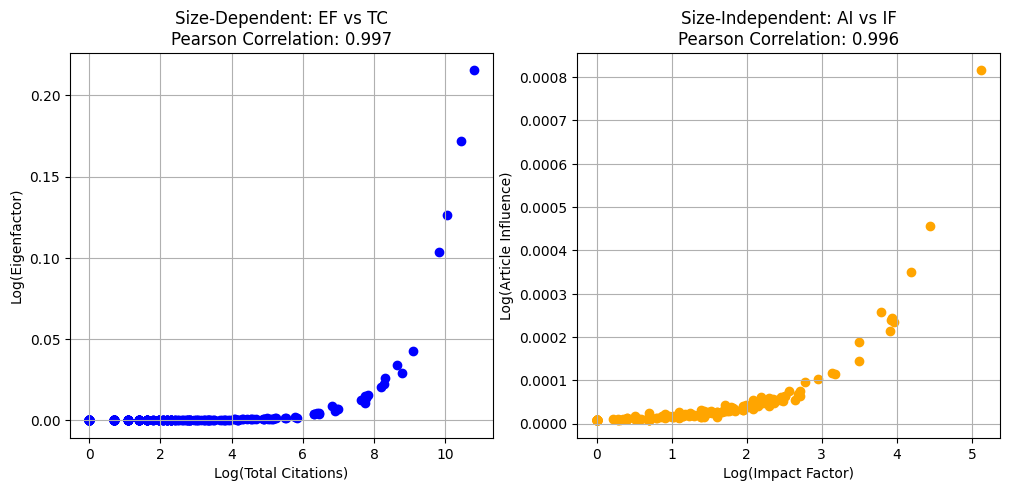

In [47]:
df_metrics = calculate_metrics_dataframe(A, z)
r1, r2 = analyse_correlations(df_metrics)
analyse_ranking_differences(df_metrics)
plot_comparisons(df_metrics, r1, r2)

There is aa very high Pearson correlation $\rho_{EF, TC}$ between EF and TC. Since both metrics are extensive (they scale with the number of articles $z$), large journals dominate both lists. There are some shifts which become more pronounced as we move away from the top journals. If a journal has a positive rank difference, it means that it has fewer raw citations, but they come from highly prestigious sources.

The primary driver for both metrics in this dataset is journal size. Large journals publish more papers, accumulate more citations (TC), and consequently receive more visits from the random surfer (EF). This size effect drowns out the subtle prestige adjustments that the PageRank algorithm attempts to make.

---

Since EF and TC are dominated by size $z$, their correlation tells us that size correlates with size. To determine if the PageRank algorithm itself adds value over simple counting, we must remove the size factor. Here, AI and IF are size-independent metrics. By comparing AI and IF, we compare the per-article quality which determines whether the PageRank algorithm adds any value over simple citation counting.

The correlation $\rho_{AI, IF}$ is also very high. It implies that in this specific high energy physics dataset, the quality of citations (measured by the eigenvector centrality) matches the quantity of citations (measured by simple counts) very well. This suggests that the network structure is highly stratified: journals with high impact factors tend to be cited by other journals with high impact factors. There are likely very few spam journals with high citations from low-quality sources or niche journals with low citations, but high prestige.